In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from globalbiopak.dataloader import loaddata

%load_ext autoreload
%autoreload 2

# Coherent random model

## With no correlation

In [24]:
size_in = 100
size_out = 484
size_out_sqrt = int(np.sqrt(size_out))
x = (torch.randn(size_in) + 1j * torch.randn(size_in)) / np.sqrt(2)
A = (torch.randn(size_out, size_in) + 1j * torch.randn(size_out, size_in)) / np.sqrt(2 * size_in)
y = torch.abs(A @ x)**2

Mean value of y: 0.9821581840515137


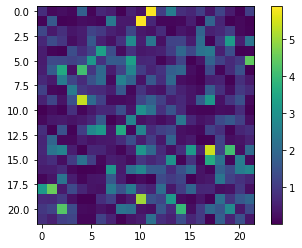

In [25]:
print(f"Mean value of y: {torch.mean(y)}")
plt.imshow(y.reshape(size_out_sqrt, size_out_sqrt))
plt.colorbar()
plt.show()

## With correlation

In [2]:
def add_output_correlation(A, grain_size=5):
    size_out = A.shape[0]
    size_out_sqrt = int(np.sqrt(size_out))
    
    pupil_radius = size_out_sqrt / grain_size
    center = size_out_sqrt / 2
    x = np.linspace(0, size_out_sqrt, size_out_sqrt, dtype=np.uint)
    xx, yy = np.meshgrid(x, x)
    pupil = ((xx-center)**2 + (yy-center)**2) > pupil_radius**2
    
    fourierA = torch.fft.fftshift(
        torch.fft.fft2(
                A.reshape(size_out_sqrt, size_out_sqrt, -1), 
                dim=(0, 1)),
        dim=(0, 1))
    fourierA[pupil, :] = 0
    return torch.fft.ifft2(torch.fft.ifftshift(fourierA), dim=(0, 1)).reshape(size_out, size_in)

In [63]:
size_in = 100
size_out = 10000
size_out_sqrt = int(np.sqrt(size_out))
x = (torch.randn(size_in) + 1j * torch.randn(size_in)) / np.sqrt(2)
A = (torch.randn(size_out, size_in) + 1j * torch.randn(size_out, size_in)) / np.sqrt(2 * size_in)
A = add_output_correlation(A, grain_size=4)
y = torch.abs(A @ x)**2

Mean value of y: 0.20137269794940948


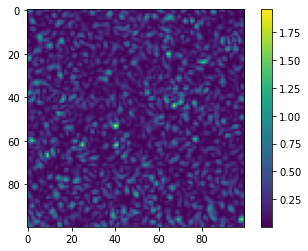

In [64]:
print(f"Mean value of y: {torch.mean(y)}")
plt.imshow(y.reshape(size_out_sqrt, size_out_sqrt))
plt.colorbar()
plt.show()

# Incoherent PSF model

In [17]:
def add_output_correlationPSF(psf, grain_size=5):
    size_out_sqrt = psf.shape[0]
    
    pupil_radius = size_out_sqrt / grain_size
    center = size_out_sqrt / 2
    x = np.linspace(0, size_out_sqrt, size_out_sqrt, dtype=np.uint)
    xx, yy = np.meshgrid(x, x)
    pupil = ((xx-center)**2 + (yy-center)**2) > pupil_radius**2
    
    fourierA = torch.fft.fftshift(torch.fft.fft2(psf), dim=(0, 1))
    fourierA[pupil, :] = 0
    return torch.fft.ifft2(torch.fft.ifftshift(fourierA))

In [34]:
size_in = 25
size_out = 10000
size_in_sqrt = int(np.sqrt(size_in))
size_out_sqrt = int(np.sqrt(size_out))
x = torch.rand(size_in_sqrt, size_in_sqrt)
psf = - torch.log(1 - torch.rand(size_out_sqrt, size_out_sqrt))  # exponential distribution, see https://stats.stackexchange.com/questions/234544/from-uniform-distribution-to-exponential-distribution-and-vice-versa
psf = torch.real(add_output_correlationPSF(psf, grain_size=1))
y = torch.nn.functional.conv2d(psf.reshape(1,1,size_out_sqrt,size_out_sqrt), x.reshape(1,1,size_in_sqrt,size_in_sqrt), padding="same")

Mean value of y: 12.042616844177246


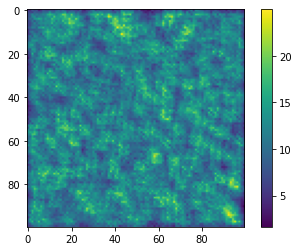

In [35]:
print(f"Mean value of y: {torch.mean(y)}")
plt.imshow(y.reshape(size_out_sqrt, size_out_sqrt))
plt.colorbar()
plt.show()

# With real image

In [38]:
size_in = 784
size_out = 10000
size_in_sqrt = int(np.sqrt(size_in))
size_out_sqrt = int(np.sqrt(size_out))
x = loaddata("MNIST").float()
psf = - torch.log(1 - torch.rand(size_out_sqrt, size_out_sqrt))  # exponential distribution, see https://stats.stackexchange.com/questions/234544/from-uniform-distribution-to-exponential-distribution-and-vice-versa
psf = torch.real(add_output_correlationPSF(psf, grain_size=1))
y = torch.nn.functional.conv2d(psf.reshape(1,1,size_out_sqrt,size_out_sqrt), x.reshape(1,1,size_in_sqrt,size_in_sqrt), padding="same")

Mean value of y: 24837.302734375


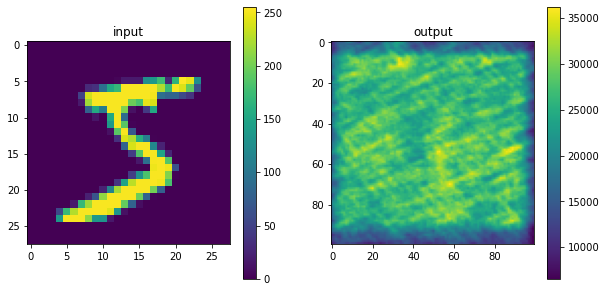

In [39]:
print(f"Mean value of y: {torch.mean(y)}")
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(x.reshape(size_in_sqrt, size_in_sqrt))
plt.title("input")
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(y.reshape(size_out_sqrt, size_out_sqrt))
plt.title("output")
plt.colorbar()
plt.show()

# Generate shift-and-add objects

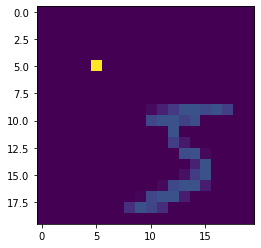

In [55]:
size_in_sqrt = 20
size_in = size_in_sqrt**2
size_out = 10000
size_out_sqrt = int(np.sqrt(size_out))

x = torch.zeros(size_in_sqrt, size_in_sqrt)
x[5, 5] = 1024
digit = loaddata("MNIST").float()
x[6:20, 6:20] = digit[::2, ::2]

plt.imshow(x);

In [56]:
psf = - torch.log(1 - torch.rand(size_out_sqrt, size_out_sqrt))  # exponential distribution, see https://stats.stackexchange.com/questions/234544/from-uniform-distribution-to-exponential-distribution-and-vice-versa
psf = torch.real(add_output_correlationPSF(psf, grain_size=1))
y = torch.nn.functional.conv2d(psf.reshape(1,1,size_out_sqrt,size_out_sqrt), x.reshape(1,1,size_in_sqrt,size_in_sqrt), padding="same")

Mean value of y: 7285.07177734375


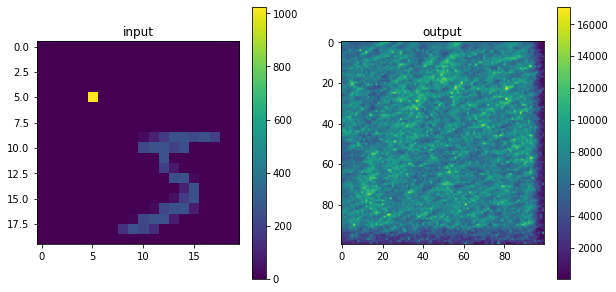

In [57]:
print(f"Mean value of y: {torch.mean(y)}")
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(x.reshape(size_in_sqrt, size_in_sqrt))
plt.title("input")
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(y.reshape(size_out_sqrt, size_out_sqrt))
plt.title("output")
plt.colorbar()
plt.show()

# Shift-and-add

In [63]:
size_in_sqrt = 20
size_in = size_in_sqrt**2
size_out = 4096
size_out_sqrt = int(np.sqrt(size_out))

x = torch.zeros(size_in_sqrt, size_in_sqrt)
x[5, 5] = 1024
digit = loaddata("MNIST").float()
x[6:20, 6:20] = digit[::2, ::2]

100%|██████████| 1000/1000 [00:06<00:00, 145.85it/s]


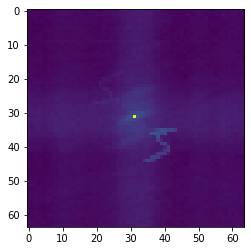

In [64]:
n_saa = 1000
saa_sum = torch.zeros(size_out_sqrt, size_out_sqrt)
for i_saa in tqdm(range(n_saa)):
    psf = - torch.log(1 - torch.rand(size_out_sqrt, size_out_sqrt))  # exponential distribution, see https://stats.stackexchange.com/questions/234544/from-uniform-distribution-to-exponential-distribution-and-vice-versa
    # psf = torch.real(add_output_correlationPSF(psf, grain_size=1))
    y = torch.nn.functional.conv2d(psf.reshape(1,1,size_out_sqrt,size_out_sqrt), x.reshape(1,1,size_in_sqrt,size_in_sqrt), padding="same")
    max_pos1D = torch.argmax(y)
    max_posX = torch.div(max_pos1D, size_out_sqrt, rounding_mode="floor")
    max_posY = max_pos1D - size_out_sqrt * max_posX
    saa_sum += torch.roll(y.reshape(size_out_sqrt, size_out_sqrt), shifts=(-max_posX+size_out_sqrt//2, -max_posY+size_out_sqrt//2), dims=(0, 1))
saa_sum = torch.flip(saa_sum, dims=(0, 1))  # because torch computes correlations and not convolutions
plt.imshow(saa_sum);